# MetaPro-IQ

In [1]:
import skbio
import pandas as pd
import numpy as np
import os 
import shutil
import scipy.stats
import scikit_posthocs as ph
import numpy as np
#import Bio
import scipy.stats
#import scikit_posthocs as ph
import numpy as np
import matplotlib_venn
import os
from matplotlib_venn import venn3, venn2
import matplotlib.pyplot as plt
from pylab import *
import matplotlib.pyplot as plt
from pylab import *
from IPython.display import Image

In [2]:
%load_ext autoreload
%autoreload 1
%aimport metanovo_functions

### 1.1 Preprocessing

In [3]:
# From the MetaNovo PRIDE project PXD030708, download mli_txt.zip, and unzip the txt folder to the below location:
metanovo_uniprot    = 'data/mli/metanovo/txt' 
assert os.path.exists(metanovo_uniprot)

In [4]:
# The Human mucosal-luminal interface mass spectrometry proteomics data are available from the ProteomeXchange Consortium via the PRIDE (25) partner repository with the dataset identifier PXD003528
# Please indicate the path to the txt folders containing the MaxQuant tables
txt_workflow = 'data/mli/txt_workflow' 
txt_matched_metagenome ='data/mli/txt_matched_metagenome'

In [5]:
outfolder = 'analysis/mli/'

In [6]:
paths = ['analysis/figures', 'analysis/supplementary' ] 
for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

In [7]:
# MetaNovo Parameters
summary = pd.read_csv(metanovo_uniprot + '/summary.txt',sep='\t')
summary[16:].stack()
parameters = pd.read_csv(metanovo_uniprot + '/parameters.txt',sep='\t')

In [8]:
# MetaNovo Summary
summary = pd.read_csv(metanovo_uniprot + '/summary.txt',sep='\t')
summary[16:].stack()

16  Raw file                                          Total
    MS                                             198071.0
    MS/MS                                          483091.0
    MS/MS Submitted                                523865.0
    MS/MS Submitted (SIL)                          442317.0
    MS/MS Submitted (ISO)                               0.0
    MS/MS Submitted (PEAK)                          81548.0
    MS/MS Identified                               190538.0
    MS/MS Identified (SIL)                         185701.0
    MS/MS Identified (ISO)                              0.0
    MS/MS Identified (PEAK)                          4837.0
    MS/MS Identified [%]                              36.37
    MS/MS Identified (SIL) [%]                        41.98
    MS/MS Identified (PEAK) [%]                        5.93
    Peptide Sequences Identified                      70063
    Peaks                                        20584507.0
    Isotope Patterns                    

In [9]:
folders = { 'MetaNovo/UniProt': metanovo_uniprot,
            'MetaPro-IQ/IGC' :txt_workflow,
            'MetaPro-IQ/Metagenome':txt_matched_metagenome}

order = ['MetaNovo/UniProt', 'MetaPro-IQ/IGC' , 'MetaPro-IQ/Metagenome']

results = {}
for name in order:
    path = folders[name]
    res = metanovo_functions.process_txt(path, name, outfolder)
    results[name] = res

Analysis: MetaNovo/UniProt
data/mli/metanovo/txt
MetaNovo/UniProt: Total peptides:  70063
MetaNovo/UniProt: Total target peptides:  69878
MetaNovo/UniProt: Total proteins:  15731
MetaNovo/UniProt: Total target proteins:  15566
MetaNovo/UniProt: Total MS/MS Identified [%]:  36.37
Analysis: MetaPro-IQ/IGC
data/mli/txt_workflow
MetaPro-IQ/IGC: Total peptides:  69051
MetaPro-IQ/IGC: Total target peptides:  68828
MetaPro-IQ/IGC: Total proteins:  19742
MetaPro-IQ/IGC: Total target proteins:  19533
Analysis: MetaPro-IQ/Metagenome
data/mli/txt_matched_metagenome
MetaPro-IQ/Metagenome: Total peptides:  71596
MetaPro-IQ/Metagenome: Total target peptides:  71390
MetaPro-IQ/Metagenome: Total proteins:  16956
MetaPro-IQ/Metagenome: Total target proteins:  16777


### 1.2 Peptide and Protein Identification Bar Charts

<Figure size 432x288 with 0 Axes>

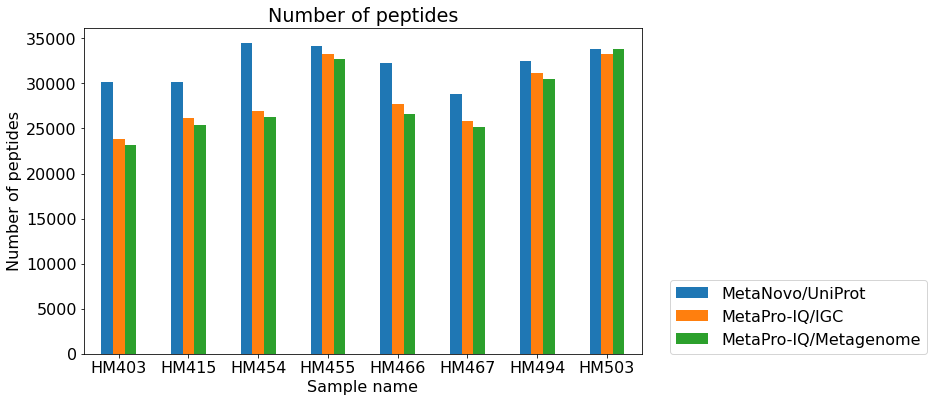

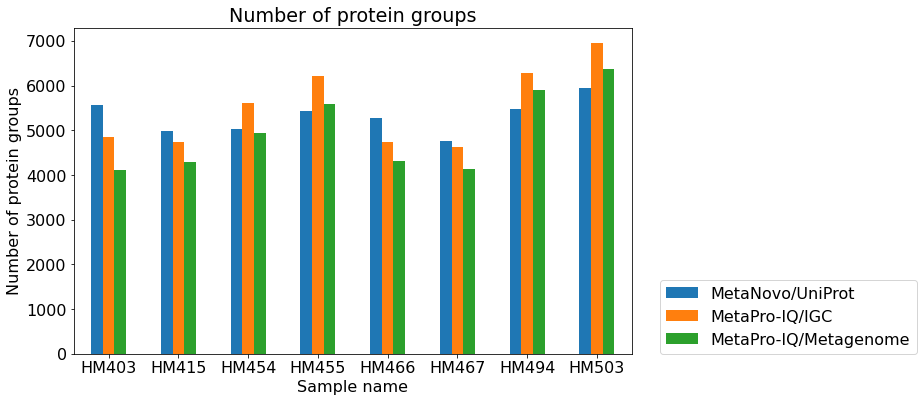

In [10]:
keys = list(results.keys())
plt.clf()
# Peptide counts per sample
count_df = pd.DataFrame()
for name in order:
    target_peptides = results[name]['TargetPeptides']
    for col in target_peptides.columns:
        if col.startswith('Experiment'):
            seqs = set(target_peptides[(target_peptides[col] > 0)]['Sequence'].tolist())
            count_df.loc[col.split()[1], name] = int(len(seqs))
ax1 = count_df.plot(kind='bar', rot=1,figsize=(10,6))
ax1.set_title("Number of peptides")
ax1.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

plt.xlabel('Sample name')
plt.ylabel('Number of peptides')
plt.xticks(rotation=0)
fig = ax1.get_figure()

fig.savefig('analysis/figures/fig_3a.png', bbox_inches='tight', dpi=600)


plt.show()

# Protein counts per sample
prot_count = pd.DataFrame()
for name in order:
    target_proteins = results[name]['TargetProteins']
    for col in target_proteins.columns:
        if col.startswith('MS/MS Count '):
            ids = set(target_proteins[(target_proteins[col] > 0)]['id'].tolist())
            prot_count.loc[col.split()[-1], name] = int(len(ids))
ax2 = prot_count.plot(kind='bar', rot=1,figsize=(10,6))
ax2.set_title("Number of protein groups")
ax2.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
plt.xticks(rotation=0)
plt.xlabel('Sample name')
plt.ylabel('Number of protein groups')
fig = ax2.get_figure()

plt.show()

### 1.3 PEP Score Boxplots

#### Fgure 3d

MetaNovo/UniProt exclusive:  14049
MetaPro-IQ/IGC exclusive:  4873
MetaPro-IQ/Metagenome exclusive:  6525


<ipython-input-11-781f403aebeb>:21: RuntimeWarning: divide by zero encountered in log10
  new_l = [np.log10(v) for v in l]


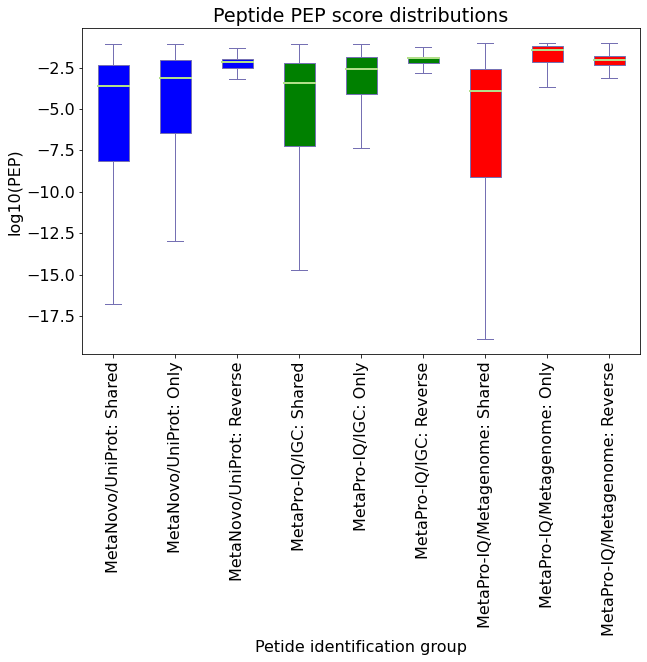

In [11]:
##################
## Peptide Sets ##
##################
all_peps = set()
keys = list(results.keys())
names = []
pep_scores = []
for key in order:
    peps = set(results[key]['TargetPeptides']['Sequence'])
    all_peps.update(peps)
# Get common peptides to all runs
intersect = all_peps.copy()
for key in order:
    peps = set(results[key]['TargetPeptides']['Sequence'])
    intersect = intersect & peps
# Get esclusive peptides for all runs

def log2(vals):
    res = []
    for l in vals:
        new_l = [np.log10(v) for v in l]
        res.append(new_l)
    return res


for key in order:
    peps = results[key]['TargetPeptides'].copy()
    rpeps = results[key]['ReversePeptides'].copy()
    
    exclusive = set(peps['Sequence'].tolist()).copy()
    for qkey in keys:
        if not qkey == key:
            qpeps = results[qkey]['TargetPeptides'] #+ results[qkey]['ReversePeptides']
            qpeps = set(qpeps['Sequence'].tolist())
            
            #qrpeps = results[qkey]['ReversePeptides'] 
            #qrpeps = set(qrpeps['Sequence'].tolist())
            
            
            exclusive = exclusive -  qpeps
            #print(len(exclusive))
    print('{} exclusive: '.format(key), len(exclusive))
    common_pep = peps[peps['Sequence'].isin(intersect)]['PEP'].tolist()
    pep_scores.append(common_pep)
    names.append(key + ': Shared')
    exclusive_pep = peps[peps['Sequence'].isin(exclusive)]['PEP'].tolist()
    pep_scores.append(exclusive_pep)
    names.append(key + ': Only')
    reverse_pep = rpeps['PEP'].tolist()
    pep_scores.append(reverse_pep)
    names.append(key + ': Reverse')
    #all_pep = peps['PEP'].tolist()
    #pep_scores.append(all_pep)
    #names.append(key + ': All')
    

#############
## BOXPLOT ##
#############
colours = ['b','g','r','c','m','y','k']
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(np.array(log2(pep_scores), dtype=object), patch_artist=True, showfliers=False)
## change outline color, fill color and linewidth of the boxes
count = 0
col_ind=0
for box in bp['boxes']:
    count += 1
    # change outline color
    box.set( color='#7570b3', linewidth=1)
    # change fill color
    box.set( facecolor = colours[col_ind] )
    ## change color and linewidth of the whiskers
    if count % 3 == 0:
        col_ind +=1
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=1)
# change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=1)
# change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)
# change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='.', color='#e7298a', alpha=0.5)
# Custom x-axis labels
ax.set_xticklabels(names, rotation=90) 
ax.set_title('Peptide PEP score distributions')
## Remove top axes and right axes ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.xlabel('Petide identification group')
plt.ylabel('log10(PEP)')
fig.savefig('analysis/figures/fig_3d.png', bbox_inches='tight',dpi=600)
plt.show()
fig.clf()

#### S3 Figure - Density plot of peptide PEP scores by group

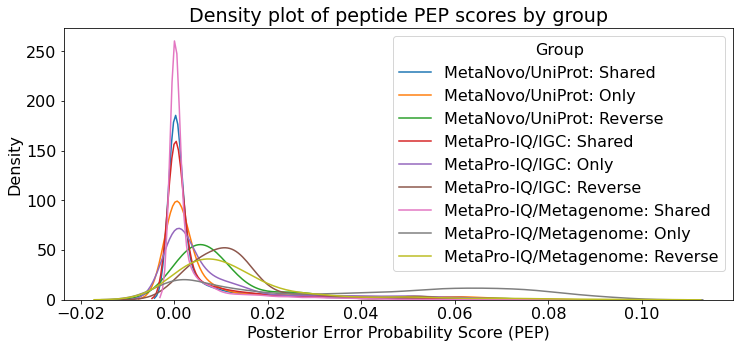

In [12]:
from sklearn.neighbors import KernelDensity
import seaborn as sns

fig = plt.figure(figsize=(12, 5))

for name in names:
    _ = pd.DataFrame( { name : pep_scores[names.index(name)] } )
    # Draw the density plot
    sns.kdeplot(pep_scores[names.index(name)], label=name)
    

# Plot formatting
plt.legend(prop={'size': 16}, title = 'Group')
plt.title('Density plot of peptide PEP scores by group')
plt.xlabel('Posterior Error Probability Score (PEP)')
plt.ylabel('Density')

fig.savefig('analysis/supplementary/S3_figure.png', bbox_inches='tight',dpi=600)
plt.show()

#### S4 Table - Peptide PEP Scores comparison

In [32]:
pep_df = pd.DataFrame()
for val in range(len(names)):
    pep_df.loc[names[val], 'Count'] = len(pep_scores[val])
    pep_df.loc[names[val], 'PEP Score - median'] = np.median(pep_scores[val])
    #pep_df.loc[names[val], 'PEP Score - mean'] = np.mean(pep_scores[val])
    pep_df.loc[names[val], 'PEP Score - std. dev.'] = np.std(pep_scores[val])

pep_df.to_excel('analysis/supplementary/S4_table.xlsx')
pep_df

Count  PEP Score - median  \
MetaNovo/UniProt: Shared        48705.0            0.000260   
MetaNovo/UniProt: Only          14049.0            0.000799   
MetaNovo/UniProt: Reverse         185.0            0.007231   
MetaPro-IQ/IGC: Shared          48705.0            0.000373   
MetaPro-IQ/IGC: Only             4873.0            0.002632   
MetaPro-IQ/IGC: Reverse           223.0            0.011263   
MetaPro-IQ/Metagenome: Shared   48705.0            0.000126   
MetaPro-IQ/Metagenome: Only      6525.0            0.038306   
MetaPro-IQ/Metagenome: Reverse    206.0            0.009337   

                                PEP Score - std. dev.  
MetaNovo/UniProt: Shared                     0.012193  
MetaNovo/UniProt: Only                       0.017173  
MetaNovo/UniProt: Reverse                    0.013012  
MetaPro-IQ/IGC: Shared                       0.013737  
MetaPro-IQ/IGC: Only                         0.016785  
MetaPro-IQ/IGC: Reverse                      0.011878  
MetaPro-IQ/Metagenome: Shared                0.008828  
MetaPro-IQ/Metagenome: Only                  0.030075  
MetaPro-IQ/Metagenome: Reverse               0.016834

### 1.4 PEP Score Kruskal-Wallis

In [34]:
post_hoc = metanovo_functions.list_kw_dunn(names, pep_scores, "PEP", "Workflow", outfolder)
post_hoc.to_excel('analysis/supplementary/S5_table.xlsx')
post_hoc

KruskalResult(statistic=10883.939894469078, pvalue=0.0)


MetaNovo/UniProt: Shared  \
MetaNovo/UniProt: Shared                    1.000000e+00   
MetaNovo/UniProt: Only                      3.734901e-87   
MetaNovo/UniProt: Reverse                   1.729789e-39   
MetaPro-IQ/IGC: Shared                      3.773263e-32   
MetaPro-IQ/IGC: Only                       4.537713e-216   
MetaPro-IQ/IGC: Reverse                     1.541020e-60   
MetaPro-IQ/Metagenome: Shared               7.627574e-72   
MetaPro-IQ/Metagenome: Only                 0.000000e+00   
MetaPro-IQ/Metagenome: Reverse              1.569875e-53   

                                MetaNovo/UniProt: Only  \
MetaNovo/UniProt: Shared                  3.734901e-87   
MetaNovo/UniProt: Only                    1.000000e+00   
MetaNovo/UniProt: Reverse                 6.330437e-26   
MetaPro-IQ/IGC: Shared                    1.158218e-32   
MetaPro-IQ/IGC: Only                      3.620188e-64   
MetaPro-IQ/IGC: Reverse                   1.281311e-41   
MetaPro-IQ/Metagenome: Shared            2.606551e-222   
MetaPro-IQ/Metagenome: Only               0.000000e+00   
MetaPro-IQ/Metagenome: Reverse            1.481513e-36   

                                MetaNovo/UniProt: Reverse  \
MetaNovo/UniProt: Shared                     1.729789e-39   
MetaNovo/UniProt: Only                       6.330437e-26   
MetaNovo/UniProt: Reverse                    1.000000e+00   
MetaPro-IQ/IGC: Shared                       7.918533e-34   
MetaPro-IQ/IGC: Only                         3.192363e-11   
MetaPro-IQ/IGC: Reverse                      2.014311e-01   
MetaPro-IQ/Metagenome: Shared                5.813792e-49   
MetaPro-IQ/Metagenome: Only                  3.362623e-02   
MetaPro-IQ/Metagenome: Reverse               3.147086e-01   

                                MetaPro-IQ/IGC: Shared  MetaPro-IQ/IGC: Only  \
MetaNovo/UniProt: Shared                  3.773263e-32         4.537713e-216   
MetaNovo/UniProt: Only                    1.158218e-32          3.620188e-64   
MetaNovo/UniProt: Reverse                 7.918533e-34          3.192363e-11   
MetaPro-IQ/IGC: Shared                    1.000000e+00         9.163935e-153   
MetaPro-IQ/IGC: Only                     9.163935e-153          1.000000e+00   
MetaPro-IQ/IGC: Reverse                   9.235974e-53          3.148180e-20   
MetaPro-IQ/Metagenome: Shared            1.125309e-194          0.000000e+00   
MetaPro-IQ/Metagenome: Only               0.000000e+00         4.475586e-267   
MetaPro-IQ/Metagenome: Reverse            1.536492e-46          1.827976e-17   

                                MetaPro-IQ/IGC: Reverse  \
MetaNovo/UniProt: Shared                   1.541020e-60   
MetaNovo/UniProt: Only                     1.281311e-41   
MetaNovo/UniProt: Reverse                  2.014311e-01   
MetaPro-IQ/IGC: Shared                     9.235974e-53   
MetaPro-IQ/IGC: Only                       3.148180e-20   
MetaPro-IQ/IGC: Reverse                    1.000000e+00   
MetaPro-IQ/Metagenome: Shared              2.271949e-73   
MetaPro-IQ/Metagenome: Only                6.870360e-01   
MetaPro-IQ/Metagenome: Reverse             7.870152e-01   

                                MetaPro-IQ/Metagenome: Shared  \
MetaNovo/UniProt: Shared                         7.627574e-72   
MetaNovo/UniProt: Only                          2.606551e-222   
MetaNovo/UniProt: Reverse                        5.813792e-49   
MetaPro-IQ/IGC: Shared                          1.125309e-194   
MetaPro-IQ/IGC: Only                             0.000000e+00   
MetaPro-IQ/IGC: Reverse                          2.271949e-73   
MetaPro-IQ/Metagenome: Shared                    1.000000e+00   
MetaPro-IQ/Metagenome: Only                      0.000000e+00   
MetaPro-IQ/Metagenome: Reverse                   3.725671e-65   

                                MetaPro-IQ/Metagenome: Only  \
MetaNovo/UniProt: Shared                       0.000000e+00   
MetaNovo/UniProt: Only                         0.000000e+00   
MetaNov

### 1.5 Venn Diagrams

#### Figure 3b

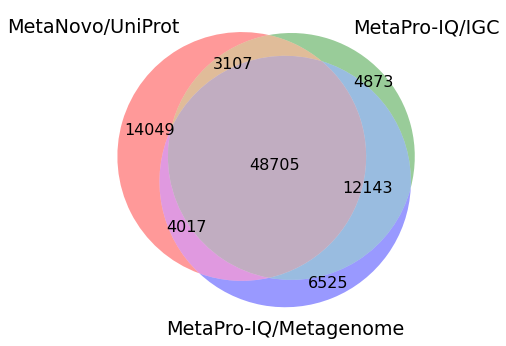

In [15]:
set1 = set(results['MetaNovo/UniProt']['TargetPeptides']['Sequence'])
set2 = set(results['MetaPro-IQ/IGC']['TargetPeptides']['Sequence'])
set3 = set(results['MetaPro-IQ/Metagenome']['TargetPeptides']['Sequence'])
fig = plt.figure(figsize=(10,6))
venn3([set1, set2, set3], ('MetaNovo/UniProt', 'MetaPro-IQ/IGC', 'MetaPro-IQ/Metagenome'))
fig.savefig('analysis/figures/fig_3b.png',dpi=600)
plt.show()

In [16]:
mg = set(results['MetaPro-IQ/Metagenome']['TargetPeptides']['Sequence']) - set(results['MetaPro-IQ/IGC']['TargetPeptides']['Sequence'])
print(len(mg))
mn = set(results['MetaNovo/UniProt']['TargetPeptides']['Sequence']) & mg
print(len(mn))

10542
4017


### 1.6 UniPept v2.0.0

In [17]:
print('All peptides found: ', len(all_peps))
w=open( outfolder + '/combined_peptide_set.txt','w')
w.write('\n'.join(all_peps))
w.close()
cmd = 'cat analysis/mli/combined_peptide_set.txt | prot2pept | peptfilter | sort -u | unipept pept2lca -e -a > analysis/mli/combined_pept2lca.csv || rm analysis/mli/combined_pept2lca.csv'
# run this in terminal
print('Please run this command in terminal in the root directory of the repo: \n' + cmd)

All peptides found:  93419
Please run this command in terminal in the root directory of the repo: 
cat analysis/mli/combined_peptide_set.txt | prot2pept | peptfilter | sort -u | unipept pept2lca -e -a > analysis/mli/combined_pept2lca.csv || rm analysis/mli/combined_pept2lca.csv


In [35]:
!cp analysis/mli/combined_pept2lca.csv analysis/supplementary/S6_table.csv
taxa = pd.read_csv('analysis/mli/combined_pept2lca.csv', low_memory=False) # Please use Supplemental Table S5 (S5_table.csv) to use the ouput of UniPept at the time of writing
template = pd.DataFrame(pd.Series(list(all_peps)))
template.rename(columns={0:'peptide'}, inplace=True)
smapping = pd.merge(template, taxa, how='inner')

#### S7-8

<Figure size 432x288 with 0 Axes>

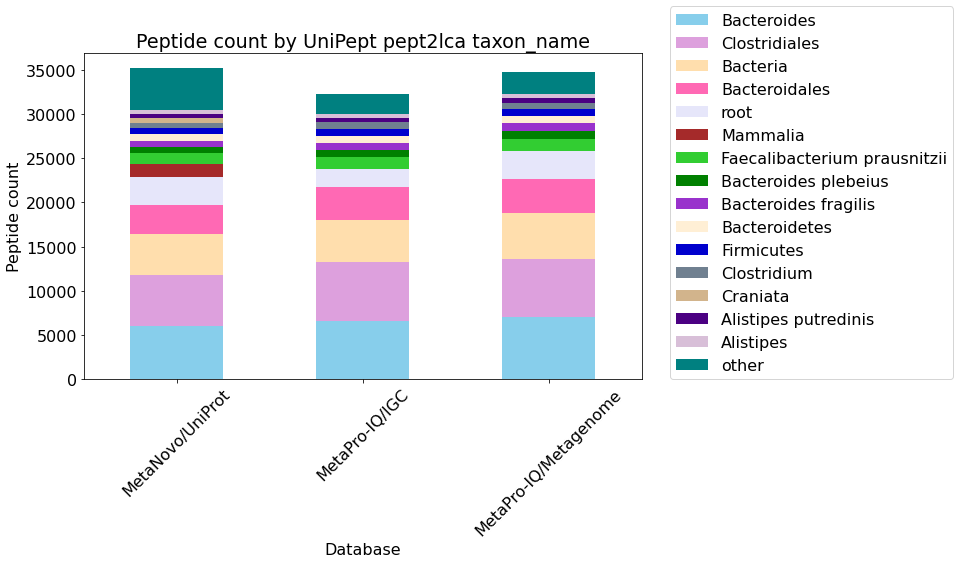

Empty DataFrame
Columns: [MetaNovo/UniProt, MetaPro-IQ/IGC, MetaPro-IQ/Metagenome]
Index: []
                  MetaNovo/UniProt  MetaPro-IQ/IGC  MetaPro-IQ/Metagenome
taxon_name                                                               
Mammalia                      1446               0                      0
Craniata                       563               0                      0
Sarcopterygii                  457               0                      0
Catarrhini                     399               0                      0
Homo sapiens                   395               0                      0
Metazoa                        378               0                      0
Simiiformes                    318               0                      0
Homininae                      280               0                      0
Eukaryota                      254               0                      0
Euarchontoglires               210               0                      0
Total              

In [36]:
order = ['MetaNovo/UniProt', 'MetaPro-IQ/IGC' , 'MetaPro-IQ/Metagenome']
count_df = metanovo_functions.plot_taxa(results, 'taxon_name', smapping, order, 0.5, level='peptide', fname='analysis/figures/fig_3c.png')
met_only_taxa = count_df[count_df['MetaPro-IQ/IGC'] == 0].copy()
met_skipped_taxa = count_df[count_df['MetaNovo/UniProt'] == 0].copy()
print(met_skipped_taxa)

met_only_taxa.loc['Total'] = met_only_taxa.sum()
met_only_taxa.to_excel('analysis/supplementary/S7_table.xlsx')
print(met_only_taxa)

count_df.loc['Total'] = count_df.sum()
count_df.to_excel('analysis/supplementary/S8_table.xlsx')
print(count_df)

<Figure size 432x288 with 0 Axes>

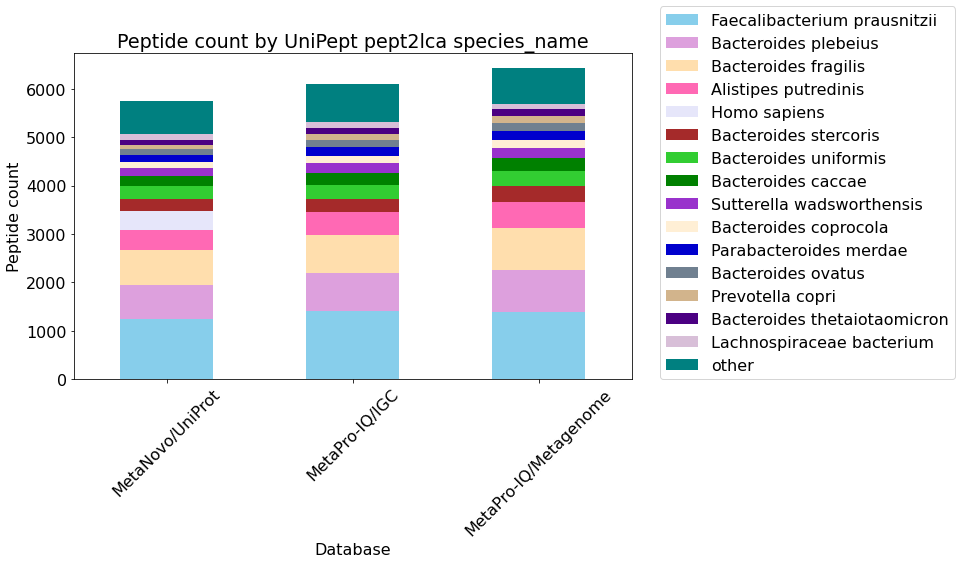

MetaNovo/UniProt  MetaPro-IQ/IGC  \
species_name                                                     
Faecalibacterium prausnitzii              1235            1404   
Bacteroides plebeius                       711             794   
Bacteroides fragilis                       715             778   
Alistipes putredinis                       419             479   
Homo sapiens                               395               0   
Bacteroides stercoris                      247             276   
Bacteroides uniformis                      267             286   
Bacteroides caccae                         216             243   
Sutterella wadsworthensis                  161             198   
Bacteroides coprocola                      132             158   
Parabacteroides merdae                     135             172   
Bacteroides ovatus                         129             147   
Prevotella copri                            82             136   
Bacteroides thetaiotaomicron                96             129   
Lachnospiraceae bacterium                  125             108   
Akkermansia muciniphila                     66             107   
Bacteroides vulgatus                        75              55   
Ruminococcus lactaris                       74              82   
Parabacteroides distasonis                  77              73   
Ruminococcaceae bacterium                   69              80   
Bacteroides dorei                           48              56   
Evtepia gabavorous                          72              72   
Bacteroides xylanisolvens                   47              53   
Dorea formicigenerans                       56              68   
Collinsella aerofaciens                     40              57   
Eggerthella lenta                           34              51   
Ruminococcus bromii                         34              36   

                              MetaPro-IQ/Metagenome  
species_name                                         
Faecalibacterium prausnitzii                   1383  
Bacteroides plebeius                            873  
Bacteroides fragilis                            866  
Alistipes putredinis                            532  
Homo sapiens                                      0  
Bacteroides stercoris                           329  
Bacteroides uniformis                           313  
Bacteroides caccae                              270  
Sutterella wadsworthensis                       209  
Bacteroides coprocola                           174  
Parabacteroides merdae                          171  
Bacteroides ovatus                              171  
Prevotella copri                                150  
Bacteroides thetaiotaomicron                    148  
Lachnospiraceae bacterium                       105  
Akkermansia muciniphila                         114  
Bacteroides vulgatus                            103  
Ruminococcus lactaris                            93  
Parabacteroides distasonis                       91  
Ruminococcaceae bacterium                        88  
Bacteroides dorei                                75  
Evtepia gabavorous                               49  
Bacteroides xylanisolvens                        69  
Dorea formicigenerans                            45  
Collinsella aerofaciens                           0  
Eggerthella lenta                                 0  
Ruminococcus bromii                               0

In [20]:
order = ['MetaNovo/UniProt', 'MetaPro-IQ/IGC' , 'MetaPro-IQ/Metagenome']
count_df = metanovo_functions.plot_taxa(results, 'species_name', smapping, order, 0.5, level='peptide')
count_df

<Figure size 432x288 with 0 Axes>

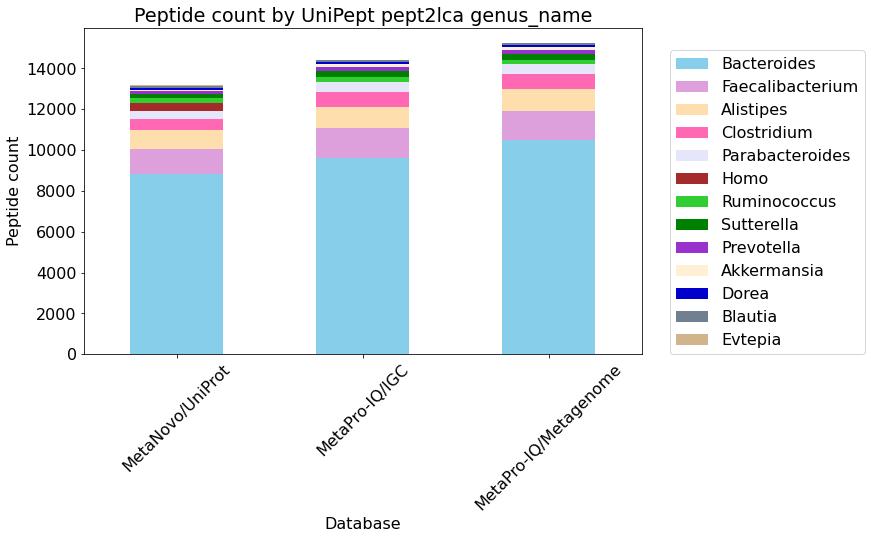

MetaNovo/UniProt  MetaPro-IQ/IGC  MetaPro-IQ/Metagenome
genus_name                                                               
Bacteroides                   8812            9631                  10476
Faecalibacterium              1265            1446                   1422
Alistipes                      886            1010                   1096
Clostridium                    584             738                    719
Parabacteroides                352             492                    492
Homo                           395               0                      0
Ruminococcus                   243             288                    205
Sutterella                     208             271                    276
Prevotella                     126             213                    230
Akkermansia                     74             114                    122
Dorea                           86             105                     88
Blautia                         92             104                     97
Evtepia                         73               0                      0

In [21]:
order = ['MetaNovo/UniProt', 'MetaPro-IQ/IGC' , 'MetaPro-IQ/Metagenome']
count_df = metanovo_functions.plot_taxa(results, 'genus_name', smapping, order, 0.5, level='peptide')
count_df

<Figure size 432x288 with 0 Axes>

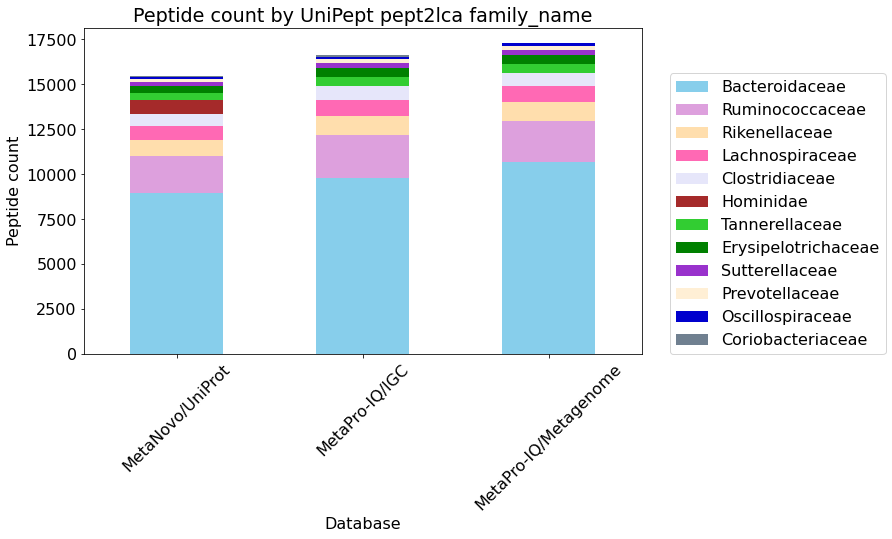

MetaNovo/UniProt  MetaPro-IQ/IGC  MetaPro-IQ/Metagenome
family_name                                                                 
Bacteroidaceae                   8989            9819                  10671
Ruminococcaceae                  2040            2394                   2269
Rikenellaceae                     894            1018                   1104
Lachnospiraceae                   787             884                    845
Clostridiaceae                    640             812                    757
Hominidae                         809               0                      0
Tannerellaceae                    356             498                    498
Erysipelotrichaceae               423             461                    473
Sutterellaceae                    213             279                    281
Prevotellaceae                    131             221                    235
Oscillospiraceae                  108             147                    143
Coriobacteriaceae                  82             121                      0

In [22]:
order = ['MetaNovo/UniProt', 'MetaPro-IQ/IGC' , 'MetaPro-IQ/Metagenome']
count_df = metanovo_functions.plot_taxa(results, 'family_name', smapping, order, 0.5, level='peptide')
count_df

<Figure size 432x288 with 0 Axes>

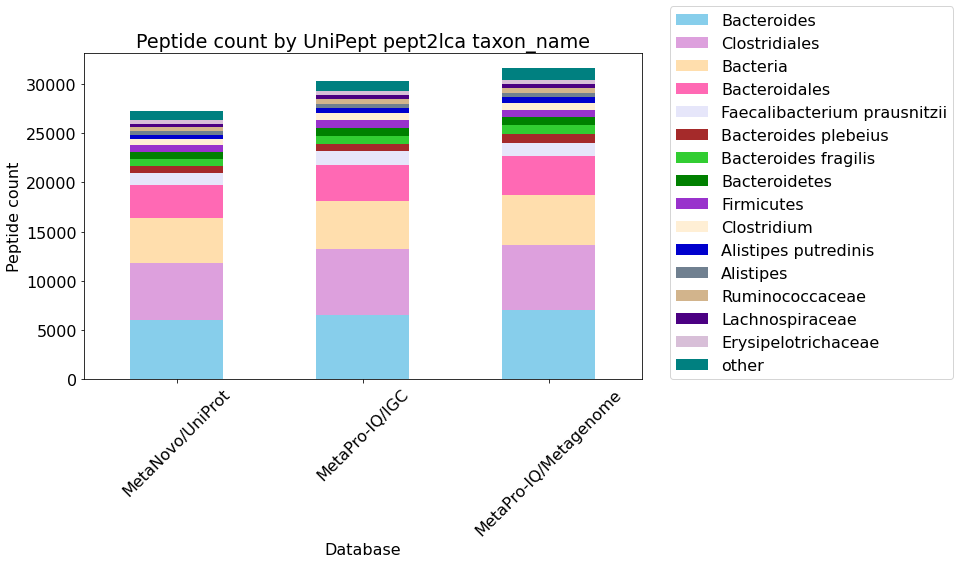

MetaNovo/UniProt  MetaPro-IQ/IGC  \
taxon_name                                                       
Bacteroides                               6025            6531   
Clostridiales                             5793            6698   
Bacteria                                  4595            4838   
Bacteroidales                             3293            3681   
Faecalibacterium prausnitzii              1235            1404   
Bacteroides plebeius                       711             794   
Bacteroides fragilis                       715             778   
Bacteroidetes                              770             799   
Firmicutes                                 706             805   
Clostridium                                580             733   
Alistipes putredinis                       419             479   
Alistipes                                  402             457   
Ruminococcaceae                            366             464   
Lachnospiraceae                            364             423   
Erysipelotrichaceae                        367             384   
Bacteroides stercoris                      247             276   
Bacteroides uniformis                      267             286   
Bacteroides caccae                         216             243   
Bacteroidia                                218             238   
Total                                    27289           30311   

                              MetaPro-IQ/Metagenome  
taxon_name                                           
Bacteroides                                    7004  
Clostridiales                                  6602  
Bacteria                                       5163  
Bacteroidales                                  3909  
Faecalibacterium prausnitzii                   1383  
Bacteroides plebeius                            873  
Bacteroides fragilis                            866  
Bacteroidetes                                   866  
Firmicutes                                      732  
Clostridium                                     717  
Alistipes putredinis                            532  
Alistipes                                       483  
Ruminococcaceae                                 470  
Lachnospiraceae                                 430  
Erysipelotrichaceae                             407  
Bacteroides stercoris                           329  
Bacteroides uniformis                           313  
Bacteroides caccae                              270  
Bacteroidia                                     242  
Total                                         31591

In [37]:
taxon_filter = {"superkingdom_name":"Bacteria"}

order = ['MetaNovo/UniProt', 'MetaPro-IQ/IGC' , 'MetaPro-IQ/Metagenome']

count_df = metanovo_functions.plot_taxa(results, 'taxon_name', smapping, order, filt=0.5, level='peptide', taxon_filter=taxon_filter, filter_method='include',fname='analysis/supplementary/S9_figure.png')
count_df = count_df.astype('int')
count_df.loc['Total'] = count_df.sum()

count_df

### S10 Table

<Figure size 432x288 with 0 Axes>

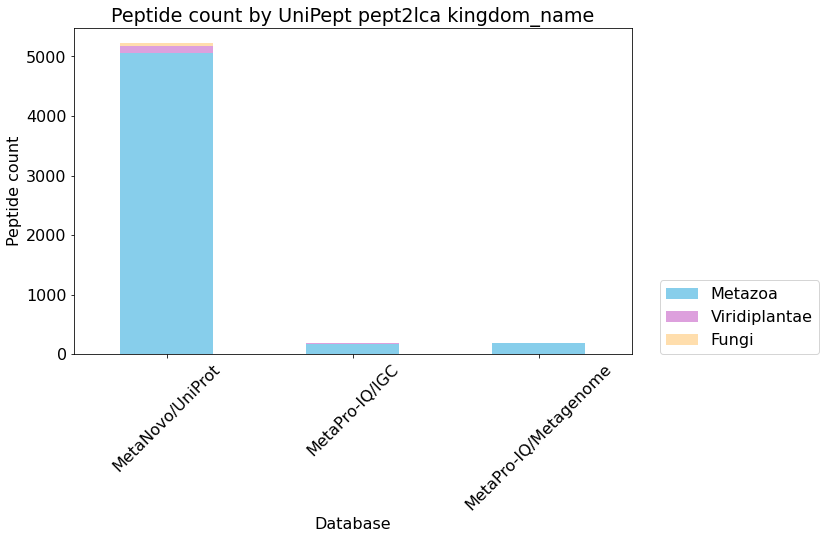

MetaNovo/UniProt  MetaPro-IQ/IGC  MetaPro-IQ/Metagenome
kingdom_name                                                          
Metazoa                    5063             178                    187
Viridiplantae               119               2                      1
Fungi                        35               5                      3
Total                      5217             185                    191

In [39]:
taxon_filter = {}
order = ['MetaNovo/UniProt', 'MetaPro-IQ/IGC' , 'MetaPro-IQ/Metagenome']
count_df = metanovo_functions.plot_taxa(results, 'kingdom_name', smapping, order, filt=0.5, level='peptide')
count_df = count_df.astype('int')
count_df.loc['Total'] = count_df.sum()
count_df.to_excel('analysis/supplementary/S10_table.xlsx')
count_df

### S11 Table

<Figure size 432x288 with 0 Axes>

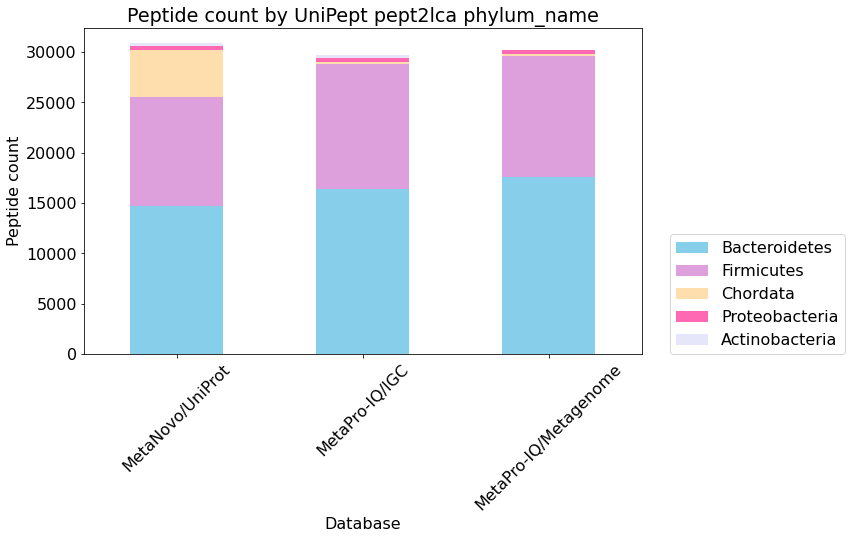

MetaNovo/UniProt  MetaPro-IQ/IGC  MetaPro-IQ/Metagenome
phylum_name                                                            
Bacteroidetes              14750           16359                  17603
Firmicutes                 10787           12494                  12033
Chordata                    4645             170                    180
Proteobacteria               405             407                    399
Actinobacteria               265             328                      0
Total                      30852           29758                  30215

In [40]:
order = ['MetaNovo/UniProt', 'MetaPro-IQ/IGC' , 'MetaPro-IQ/Metagenome']
count_df = metanovo_functions.plot_taxa(results, 'phylum_name', smapping, order, 0.5, level='peptide')
count_df.loc['Total'] = count_df.sum()
count_df.to_excel('analysis/supplementary/S11_table.xlsx')
count_df

<Figure size 432x288 with 0 Axes>

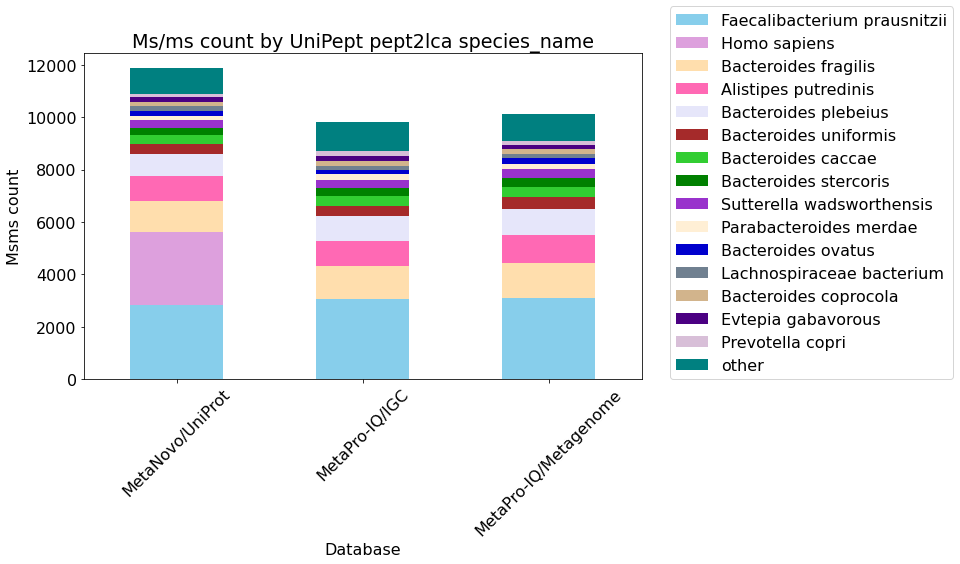

MetaNovo/UniProt  MetaPro-IQ/IGC  \
species_name                                                     
Faecalibacterium prausnitzii              2846            3058   
Homo sapiens                              2768               0   
Bacteroides fragilis                      1198            1260   
Alistipes putredinis                       928             972   
Bacteroides plebeius                       863             938   
Bacteroides uniformis                      378             390   
Bacteroides caccae                         329             360   
Bacteroides stercoris                      289             313   
Sutterella wadsworthensis                  285             305   
Parabacteroides merdae                     169             217   
Bacteroides ovatus                         171             180   
Lachnospiraceae bacterium                  207             161   
Bacteroides coprocola                      153             186   
Evtepia gabavorous                         189             196   
Prevotella copri                            97             176   
Bacteroides thetaiotaomicron               121             160   
Bacteroides vulgatus                       110              77   
Dorea formicigenerans                      131             141   
Parabacteroides distasonis                 105              98   
Akkermansia muciniphila                     70             109   
Ruminococcus lactaris                       88             102   
Bacteroides dorei                           74              87   
Ruminococcaceae bacterium                   87              91   
Collinsella aerofaciens                     58              77   
Bacteroides xylanisolvens                   55              61   
Eggerthella lenta                           54              72   
Ruminococcus bromii                         35              36   

                              MetaPro-IQ/Metagenome  
species_name                                         
Faecalibacterium prausnitzii                   3082  
Homo sapiens                                      0  
Bacteroides fragilis                           1364  
Alistipes putredinis                           1049  
Bacteroides plebeius                           1009  
Bacteroides uniformis                           430  
Bacteroides caccae                              388  
Bacteroides stercoris                           366  
Sutterella wadsworthensis                       327  
Parabacteroides merdae                          210  
Bacteroides ovatus                              214  
Lachnospiraceae bacterium                       151  
Bacteroides coprocola                           205  
Evtepia gabavorous                              128  
Prevotella copri                                156  
Bacteroides thetaiotaomicron                    173  
Bacteroides vulgatus                            144  
Dorea formicigenerans                           100  
Parabacteroides distasonis                      122  
Akkermansia muciniphila                         115  
Ruminococcus lactaris                           114  
Bacteroides dorei                               105  
Ruminococcaceae bacterium                        97  
Collinsella aerofaciens                           0  
Bacteroides xylanisolvens                        75  
Eggerthella lenta                                 0  
Ruminococcus bromii                               0

In [26]:
order = ['MetaNovo/UniProt', 'MetaPro-IQ/IGC' , 'MetaPro-IQ/Metagenome']
count_df = metanovo_functions.plot_taxa(results, 'species_name', smapping, order, level='msms', filt=0.5)
count_df

# Figure 3

In [27]:
metanovo_functions.concat_4way_image('analysis/figures/fig_3a.png',
                                     'analysis/figures/fig_3b.png',
                                     'analysis/figures/fig_3c.png',
                                     'analysis/figures/fig_3d.png',
                                     'analysis/figures/fig_3_combined.png' )